# Embedding Generation
Technical Walkthrough:

1. Create a N dimensional latent space based on a corpus of words
2. Query that space given a set of 2D coordinates
3. Pick a word from the embedding space and use that as the search query on “Twitter” (in the future we can maybe use a passage of books/poetry/etc.)
4. Take the content returned and pass to eleven labs for TTS
5. Play TTS in the 3D experience
6. Repeat this loop

## Create set of bible verses

In [24]:
# Bible from https://www.gutenberg.org/ebooks/10
from bs4 import BeautifulSoup

with open("bible.html") as fp:
    soup = BeautifulSoup(fp)

genesis = soup.find_all(class_="chapter")[1]
genesis_verses = []

for verse in genesis.stripped_strings:
    genesis_verses.append(verse)

print(len(genesis_verses))

1223


## Create embedding space

In [32]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-mpnet-base-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [72]:
embeddings = model.encode(genesis_verses, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
print(embeddings.shape)

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

(1223, 768)


/Users/sehmon/Development/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


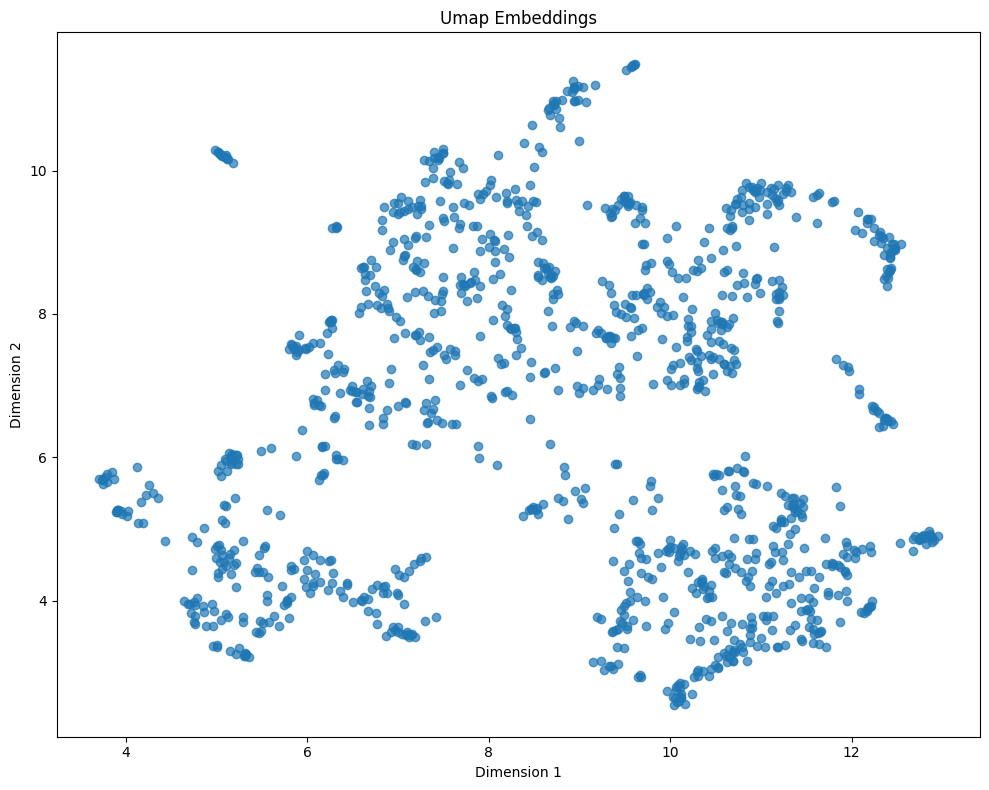

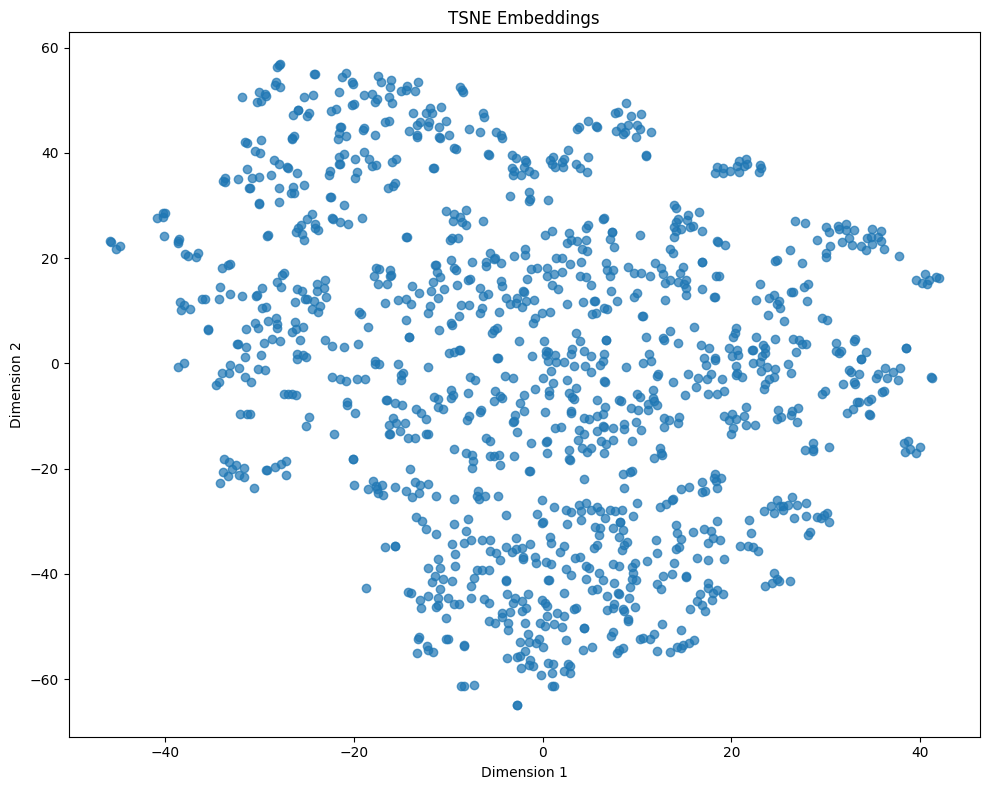

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap

def reduce_embeddings(embeddings, method='umap', n_components=2):
    """
    Reduce high-dimensional embeddings to 2D or 3D
    
    Parameters:
    - embeddings: NumPy array of embeddings
    - method: 'umap' or 'tsne'
    - n_components: 2 or 3 dimensions
    
    Returns:
    Reduced embeddings
    """
    if method == 'umap':
        reducer = umap.UMAP(
            n_components=n_components, 
            random_state=42,  # for reproducibility
            n_neighbors=15,   # adjust based on your data
            min_dist=0.1      # controls spread of points
        )
    elif method == 'tsne':
        reducer = TSNE(
            n_components=n_components, 
            random_state=42,
            perplexity=30     # adjust based on your data size
        )
    else:
        raise ValueError("Method must be 'umap' or 'tsne'")
    
    return reducer.fit_transform(embeddings)

def plot_reduced_embeddings(reduced_embeddings, labels=None, plot_title="Embedding Space Visualization"):
    """
    Plot reduced embeddings
    
    Parameters:
    - reduced_embeddings: Numpy array of reduced embeddings
    - labels: Optional list of labels for coloring/annotation
    """
    plt.figure(figsize=(10, 8))
    
    if labels is not None:
        # Color-code points by labels
        unique_labels = list(set(labels))
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
        
        for label, color in zip(unique_labels, colors):
            mask = [l == label for l in labels]
            plt.scatter(
                reduced_embeddings[mask, 0], 
                reduced_embeddings[mask, 1], 
                label=label, 
                color=color, 
                alpha=0.7
            )
        plt.legend()
    else:
        # Simple scatter plot if no labels
        plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7)
    
    plt.title(plot_title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.tight_layout()
    plt.show()

# Usage example
# Assuming 'embeddings' is your NumPy array of embeddings
# and 'genesis_verses' is your list of original text

# Reduce embeddings using UMAP
umap_embeddings = reduce_embeddings(embeddings, method='umap')
plot_reduced_embeddings(umap_embeddings, plot_title="Umap Embeddings")

# Reduce embeddings using t-SNE
tsne_embeddings = reduce_embeddings(embeddings, method='tsne')
plot_reduced_embeddings(tsne_embeddings, plot_title="TSNE Embeddings")

In [77]:
def get_original_from_point(embeddings, original_data, point):
    """
    Given a point in the embedding space, find the closest original data point.
    
    Parameters:
    embeddings (numpy.ndarray): The embedding matrix, where each row is an embedding.
    original_data (list): The original data points (e.g., text) corresponding to the embeddings.
    point (numpy.ndarray): The 2D point in the embedding space to query.
    
    Returns:
    The original data point (e.g., text) corresponding to the closest embedding to the given point.
    """
    # Calculate the distance between the query point and all embeddings
    distances = np.linalg.norm(embeddings - point, axis=1)
    
    # Find the index of the closest embedding
    closest_idx = np.argmin(distances)
    
    # Return the original data point corresponding to the closest embedding
    return original_data[closest_idx]

# Example usage
embeddings_np = umap_embeddings # Your embedding matrix
original_data = genesis_verses # Your list of original data points (e.g., text)
query_point = np.array([2, 2.5])

closest_original = get_original_from_point(embeddings_np, original_data, query_point)
print(closest_original)

8:14 And in the second month, on the seven and twentieth day of the month, was
the earth dried.


In [80]:
import pandas as pd
dataset = pd.DataFrame({'verse': genesis_verses, 'tsne_embedding': tsne_embeddings.tolist()})
print(dataset)

                                                  verse  \
0               The First Book of Moses: Called Genesis   
1     1:1 In the beginning God created the heaven an...   
2     1:2 And the earth was without form, and void; ...   
3     1:3 And God said, Let there be light: and ther...   
4     1:4 And God saw the light, that it was good: a...   
...                                                 ...   
1218  50:22 And Joseph dwelt in Egypt, he, and his f...   
1219  50:23 And Joseph saw Ephraim’s children of the...   
1220  50:24 And Joseph said unto his brethren, I die...   
1221  50:25 And Joseph took an oath of the children ...   
1222  50:26 So Joseph died, being an hundred and ten...   

                                 tsne_embedding  
0      [-11.642608642578125, 37.19331741333008]  
1       [-25.25911521911621, 50.65718078613281]  
2      [-26.451208114624023, 47.28328323364258]  
3     [-30.216901779174805, 49.665931701660156]  
4     [-29.870094299316406, 49.8651962280

In [82]:
dataset.to_csv('genesis_embeddings.csv', index=False)